# TensorFlow
Woo, it's tensorflow again. Let's build some graphs!

## Programming Model
Tensorflow expresses a numeric computation as a graph. Each node is an operation which has any number of inputs and outputs. Each edge is a tensor which flows between nodes. Suppose we have a simple network expressed by the following operation(s).

$$
h = \text{ReLU}(Wx + b)
$$

We can interpret it as three sequential operations.
![tf-graph](./assets/07_tf_graph.png)

## Node Types
New nodes are automatically built into the underlying graph. We can inspect what are the nodes inside our graph using `get_operations` on our default graph. As we can see there are multiple types of node.
```
tf.get_default_graph().get_operations()
```

### Variables
Variables are stateful nodes which output their current value. State is retained across multiple executions of a graph. We can think of variables as the parameters we wish to tune. The training will be occurred on variables instead of placeholders.
```python
b = tf.Variable(tf.zeros((100,)))
W = tf.Variable(tf.random_uniform((784, 100), -1, 1))
```

### Placeholder
Placeholders are nodes whose value is fed in at execution time.
```python
x = tf.placeholder(tf.float32, (100, 784))
```

### Mathematical operation
For example, we have `MatMul`, `Add`, `ReLU` and the list goes on.
```python
h = tf.nn.relu(tf.matmul(x, W), + b)
```

## Session
Once a graph is defined, we can deploy it with a session, which is a binding to a particular execution context. The `run` method has the followng signature.
```
sess.run(fetches, feeds)
```

### Arguments
There are two arguments we need to supply to a session.
* Fetches - List of graph nodes which will return outputs of these nodes
* Feeds - Dictionary mapping from graph nodes to concrete values which will specify the value of placeholder.

```python
sess = tf.Session()
sess.run(tf.initialize_all_variables())
sess.run(h, {x: np.random.random(100, 784)})
```

### Losses
Since labels are not parameters we are going to tune, we will use placeholder for them. In fact, loss is just a mathematical operation node.
```python
prediction = tf.nn.softmax(...) # Output of a neural network
label = tf.placeholder(tf.float32, [100, 10])
cross_entropy = -tf.reduce_sum(label * tf.log(prediction), axis=1)
```

### Optimizer
It's time to compute gradients! We need to first define an optimizer object. This should be a familiar concept to me, I have written many different types of optimizer in CS231n. 
```python
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
```

Each graph node has attached gradient operation. The gradient operation computes local gradient and combines it with upstream gradient with respect to loss. In order to use the gradient to update our parameters, we simply run the training step in a session.
```python
sess = tf.Session()
sess.run(tf.initialize_all_variables())
for i in range(1000):
    batch_x, batch_y = data.next_batch()
    sess.run(train_step, feed_dict={x: batch_x, label: batch_y})
```

### Shared Variables
What if you are running multiple sessions on a cluster of computers but you are still training one model, i.e. the same set of variables is being used across multiple machines/sessions? We can use `variable_scope`!
```python
with tf.variable_scope('foo'):
    v = tf._get_variable('v', shape=[1]) # v.name == "foo/v:0"
   
with tf.variable_scope('foo', reuse=True):
    v1 = tf.get_variable('v') # shared variable found!
   
with tf.variable_scope('foo', reuse=False):
    v1 = tf.get_variable('v') # CRASH foo/v:0 already exists
```

`variable_scope()` provides simple name-spacingto avoid clashes. `get_variable()` creates/accesses variables from within a variable scope. 
  

## Demo: Linear Regression

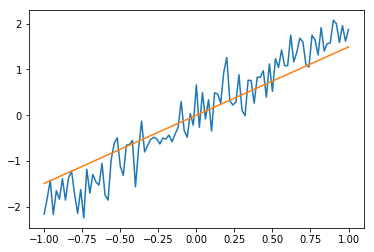

In [49]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf


def generate_dataset():
    x_batch = np.linspace(-1, 1, 101)
    y_batch = 2 * x_batch + np.random.randn(*x_batch.shape) * 0.3 # Give it some noise
    return x_batch, y_batch


def linear_regression():
    x = tf.placeholder(tf.float32, shape=(None,), name='x') # Shape none makes it flexible
    y = tf.placeholder(tf.float32, shape=(None,), name='y')
    
    with tf.variable_scope('linreg') as scope:
        w = tf.Variable(np.random.normal(), name='W')
        y_pred = tf.multiply(x, w)
        loss = tf.reduce_mean(tf.square(y_pred - y))
    
    return x, y, y_pred, loss


def train():
    x_batch, y_batch = generate_dataset()
    x, y, y_pred, loss = linear_regression()
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        feed_dict = {x: x_batch, y: y_batch} # x is a tensor placeholder and is hashable
        for i in range(30):
            loss_val, _ = sess.run([loss, optimizer], feed_dict)
        
        y_pred_batch = sess.run(y_pred, {x: x_batch})
    
    plt.plot(x_batch, y_batch, x_batch, y_pred_batch)
    plt.show()

train()

## Demo: Word2Vec Skip-Gram

Each unprocessed input is a sentence. For example, "Ever since I use TypeScript, I can't go back to JavaScript".
For a window size of 1, the processed dataset should look like
```python
(['Ever', 'I'], 'since'), (['since', 'use'], 'I'), (['I', 'TypeScript'], 'use'), ...
```

Skip-Gram model tries to predict each context word from its target word. The final data set will look like.
```python
('since', 'Ever'), ('since', 'I'), ('I', 'since'), ('I', 'use'), ...
```

### Load data
We need to load data and massage them into the correct shape.

In [1]:
import numpy as np
import tensorflow as tf
import os
import zipfile
import collections
import random
import argparse
import sys

from tempfile import gettempdir
from six.moves import urllib


def download(filename, expected_bytes):
    """Download a zip folder to temp folder on Linux"""
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url+filename, local_filename)

    statinfo = os.stat(local_filename)
    if statinfo.st_size != expected_bytes:
        raise Exception('wrong size ' + statinfo.st_size + ' failed to verify ' + filename)
    
    return local_filename


def read_data(filename):
    """Extract the file file enclosed in a zip file as a list of strings"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    
    return data


def build_dataset(words, vocab_size):
    """Builds a dataset, which is a list of integers. Each integer maps to a word."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocab_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0: # Equivalent to dictionary['UNK']
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


def generate_batch(raw_data, batch_size, num_skips, skip_window):
    """Generate a training batch for the skip-gram model"""
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [skip_window target skip_window]
    buffer = collections.deque(maxlen=span) 

    if data_index + span > len(raw_data):
        data_index = 0

    buffer.extend(raw_data[data_index:data_index+span])
    data_index += span
    for i in range(batch_size//num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j] = buffer[context_word]

        if data_index == len(data):
            buffer.extend(raw_data[0:span])
            data_index = span
        else:
            buffer.append(raw_data[data_index])
            data_index += 1

    data_index = (data_index + len(raw_data) - span) % len(raw_data)
    return batch, labels

In [4]:
url = 'http://mattmahoney.net/dc/'
vocabulary_size = 50000
data_index = 0

filename = download('text8.zip', 31344016)
word_list = read_data(filename)
data, count, dictionary, reverse_dictionary = build_dataset(word_list, vocabulary_size)

print 'loaded %s' % filename
print 'word count %d' % len(word_list)
print 'most common words (+UNK)', count[:5]
print 'sample data'
print data[:10]
print [reverse_dictionary[i] for i in data[:10]]

loaded /tmp/text8.zip
word count 17005207
most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
sample data
[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### To `numpy.Array`
Now we need to turn these data into numpy array so we can feed them into our tensorflow graph.

In [5]:
def generate_batch(raw_data, batch_size, num_skips, skip_window):
    """Generate a training batch for the skip-gram model"""
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [skip_window target skip_window]
    buffer = collections.deque(maxlen=span) 

    if data_index + span > len(raw_data):
        data_index = 0

    buffer.extend(raw_data[data_index:data_index+span])
    data_index += span
    for i in range(batch_size//num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j] = buffer[context_word]

        if data_index == len(data):
            buffer.extend(raw_data[0:span])
            data_index = span
        else:
            buffer.append(raw_data[data_index])
            data_index += 1

    data_index = (data_index + len(raw_data) - span) % len(raw_data)
    return batch, labels

The following is an example of how a batch input is mapped to a batch label.

In [7]:
batch, labels = generate_batch(data, batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]]

2 of -> 195 term
2 of -> 3137 abuse
3137 abuse -> 2 of
3137 abuse -> 46 first
46 first -> 59 used
46 first -> 3137 abuse
59 used -> 46 first
59 used -> 156 against


### Build a graph

In [8]:
batch_size = 128
embedding_size = 128 # Dimension of embedding vector
skip_window = 1
num_skips = 2
num_sampled = 64

# Construct validation set
valid_size = 16
valid_examples = np.random.choice(100, valid_size, replace=False)

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=(batch_size))
        train_labels = tf.placeholder(tf.int32, shape=(batch_size, 1))
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    with tf.device('/cpu:0'):
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(tf.random_uniform((vocabulary_size, embedding_size), -1, 1))
            embed_lookup = tf.nn.embedding_lookup(embeddings, train_inputs)

        with tf.name_scope('weights'):
            nce_weights = tf.Variable(tf.truncated_normal((vocabulary_size, embedding_size), stddev=1 / np.sqrt(embedding_size)))

        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros((vocabulary_size)))

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
                tf.nn.nce_loss(
                    weights=nce_weights,
                    biases=nce_biases,
                    labels=train_labels,
                    inputs=embed_lookup,
                    num_sampled=num_sampled,
                    num_classes=vocabulary_size))
        
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    # Compute cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embed_lookup = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embed_lookup, normalized_embeddings, transpose_b=True)
    init = tf.global_variables_initializer()

### Train it
Once the graph is built, we can start a new session to execute the graph.

In [9]:
num_steps = 100001
with tf.Session(graph=graph) as sess:
    init.run() # Initialize variables, e.g. embedding vectors
    print 'graph variables initialized'
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(data, batch_size, num_skips, skip_window)
        feed_dict = { train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000

            # The average loss is an estimate of the loss over the last 2000 batches.
            print 'average loss at step ', step, ': ', average_loss
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    print '%s %s,' % (log_str, close_word)

graph variables initialized
average loss at step  0 :  269.2176513671875
Nearest to zero: sally,
Nearest to zero: peptidoglycan,
Nearest to zero: generalized,
Nearest to zero: compelled,
Nearest to zero: dorn,
Nearest to zero: secondo,
Nearest to zero: rem,
Nearest to zero: bromine,
Nearest to into: iconoclastic,
Nearest to into: formats,
Nearest to into: nanda,
Nearest to into: posterity,
Nearest to into: dethroned,
Nearest to into: irian,
Nearest to into: coo,
Nearest to into: cleaned,
Nearest to called: aerobatics,
Nearest to called: dramatization,
Nearest to called: protecting,
Nearest to called: boats,
Nearest to called: varphi,
Nearest to called: births,
Nearest to called: imposed,
Nearest to called: atum,
Nearest to than: believes,
Nearest to than: occupation,
Nearest to than: raven,
Nearest to than: disrupted,
Nearest to than: overlaid,
Nearest to than: downgraded,
Nearest to than: rains,
Nearest to than: nikita,
Nearest to use: industrialization,
Nearest to use: birger,
Neares

average loss at step  22000 :  7.0178017911911015
average loss at step  24000 :  6.923363940238953
average loss at step  26000 :  6.825277869462967
average loss at step  28000 :  6.412920020341873
average loss at step  30000 :  6.001151402592659
Nearest to zero: six,
Nearest to zero: eight,
Nearest to zero: four,
Nearest to zero: five,
Nearest to zero: seven,
Nearest to zero: nine,
Nearest to zero: three,
Nearest to zero: abet,
Nearest to into: from,
Nearest to into: with,
Nearest to into: in,
Nearest to into: by,
Nearest to into: to,
Nearest to into: jeremiah,
Nearest to into: as,
Nearest to into: and,
Nearest to called: varphi,
Nearest to called: or,
Nearest to called: aerobatics,
Nearest to called: khoisan,
Nearest to called: dramatization,
Nearest to called: rainfall,
Nearest to called: and,
Nearest to called: hbox,
Nearest to than: occupation,
Nearest to than: much,
Nearest to than: wear,
Nearest to than: raven,
Nearest to than: sod,
Nearest to than: or,
Nearest to than: believes,

average loss at step  52000 :  5.0292595138549805
average loss at step  54000 :  5.186040455818176
average loss at step  56000 :  5.065717501759529
average loss at step  58000 :  5.057817447185516
average loss at step  60000 :  4.942558523774147
Nearest to zero: eight,
Nearest to zero: seven,
Nearest to zero: six,
Nearest to zero: five,
Nearest to zero: nine,
Nearest to zero: four,
Nearest to zero: three,
Nearest to zero: ursus,
Nearest to into: from,
Nearest to into: with,
Nearest to into: under,
Nearest to into: on,
Nearest to into: jeremiah,
Nearest to into: in,
Nearest to into: against,
Nearest to into: by,
Nearest to called: khoisan,
Nearest to called: and,
Nearest to called: varphi,
Nearest to called: while,
Nearest to called: pulau,
Nearest to called: ursus,
Nearest to called: selig,
Nearest to called: bennett,
Nearest to than: or,
Nearest to than: much,
Nearest to than: occupation,
Nearest to than: episkopos,
Nearest to than: wear,
Nearest to than: and,
Nearest to than: sod,
Ne

average loss at step  82000 :  4.7797620091438295
average loss at step  84000 :  4.752748112916946
average loss at step  86000 :  4.782512287139893
average loss at step  88000 :  4.751528748512268
average loss at step  90000 :  4.954184674978256
Nearest to zero: eight,
Nearest to zero: five,
Nearest to zero: six,
Nearest to zero: seven,
Nearest to zero: four,
Nearest to zero: nine,
Nearest to zero: three,
Nearest to zero: ursus,
Nearest to into: from,
Nearest to into: with,
Nearest to into: under,
Nearest to into: through,
Nearest to into: in,
Nearest to into: to,
Nearest to into: against,
Nearest to into: on,
Nearest to called: khoisan,
Nearest to called: pulau,
Nearest to called: selig,
Nearest to called: ursus,
Nearest to called: UNK,
Nearest to called: cnd,
Nearest to called: varphi,
Nearest to called: bennett,
Nearest to than: or,
Nearest to than: much,
Nearest to than: episkopos,
Nearest to than: occupation,
Nearest to than: wear,
Nearest to than: and,
Nearest to than: env,
Neare

### Visualization
I can visualize it with PCA but in general PCA doesn't perform well on these non-linear features. t-SNE is the typical go-to choice for machine learning.

![tsne](./assets/07_tsne.png)